In [11]:
import sys
from os import sep, remove, getcwd
from os.path import join, sep
from glob import glob
import numpy as np
import re
from itertools import islice
import time
import matplotlib.pyplot as plt

start_time = time.time()
def indices(lst, item):
    return [i for i, x in enumerate(lst) if x == item]

In [12]:
path_curr = getcwd()
rsm_path=join(path_curr,'CO2_ECLIPSE.RSM')
model_dims=[82,82,20]
grid_size=[106,106,6.1]
skip_line = 6 # this includes everything above the actual data

# Initialize the time steps
time_steps = []

# Find data block and get the time steps
fid=open(rsm_path,'r')
for _ in range(skip_line):
    next(fid)
for line in fid:
    line_bits = re.split(r'\s+', line)
    line_bits_clean = [i for i in line_bits if i]
    if line_bits_clean == []:
        break
    time_steps.append(float(line_bits_clean[0]))
fid.close()

# Get the number of time steps
steps = len(time_steps)
num_cells = model_dims[0]*model_dims[1]*model_dims[2]

# Initialize the data structures for saturation and pressure
#sats = np.zeros((*model_dims, steps))
data_object = np.zeros((num_cells, steps)) 

#i=1
cell_count = 0
# loop through file every 6+steps lines (chunks of data) at a time
last_entry=[]
with open(rsm_path,'r') as fid:
    while True:
        next_n_lines = list(islice(fid,skip_line+steps))
        if not next_n_lines:
            break
        col_name=re.split(r'\s+',next_n_lines[2])
        col_name_clean = [i for i in col_name if i]
        # if col name contains BGSAT, get the index
        ind=[]
        if "BGSAT" in col_name_clean:
            ind=indices(col_name_clean, "BGSAT")
            #if i==1499:
            #    last_entry=next_n_lines
            chunck_list = []
            for k in range(skip_line,steps+skip_line):
                chunck_bits = re.split(r'\s+',next_n_lines[k])
                chunch_bits_clean = [chunck for chunck in chunck_bits if chunck]
                chunck_list.append(chunch_bits_clean)
            for n in range(len(ind)):
                for j in range(steps):
                    index = ind[n]
                    data_object[cell_count][j]=chunck_list[j][index]
                cell_count = cell_count + 1
        #i+=1
        
# reshape data into 4D array
data_object_reshape = data_object.reshape((model_dims[0],model_dims[1],model_dims[2],steps), order='F') 
# order is [row-x down, col-y right, z, time_step]
#data_object_time1 = data_object_reshape[:,:,1,34]

# Considering only the last time step
data_object_last_time=data_object_reshape[1:model_dims[0]-1,1:model_dims[1]-1,:,steps-1]

# Read porosity and construct porosity map
poro_path=join(path_curr,'PORO.DAT')
total_num_cells = (model_dims[0])*(model_dims[1])*model_dims[2]
poro_object = []
with open(poro_path) as f:
    next(f)
    for line in f:
        if line == '/\n':
            break
        poro_object.append(float(line))
# reshape porosity
poro_obj_array = np.array(poro_object)
poro_object_reshape = poro_obj_array.reshape((model_dims[0],model_dims[1],model_dims[2]), order='F')
poro_aquifer = poro_object_reshape[1:model_dims[0]-1, 1:model_dims[1]-1, :]

unit_volume = grid_size[0]*grid_size[1]*grid_size[2]

# occupied by CO2
co2_vol_matrix_1 = np.multiply(data_object_last_time, poro_aquifer)
co2_vol_matrix = np.multiply(co2_vol_matrix_1, unit_volume)
co2_vol = np.sum(co2_vol_matrix)

# Find the box that defines the plume
xmin=0
xmax=0
ymin=0
ymax=0

sat_sum_x = []
sat_sum_y = []
# Loop through x-z plane (axis 0 of data_object_last_time, and x is down, z is right)
# The first none zero is min, and the last none zero is max
for i in range(model_dims[0]-2):
    sat_sum_x.append(np.sum(data_object_last_time[i,:,:]))

# Loop through y-z plane (axis 0 of data_object_last_time, and y is down, z is right)
# The first none zero is min, and the last none zero is max
for j in range(model_dims[1]-2):
    sat_sum_y.append(np.sum(data_object_last_time[:,j,:]))
    
    
xmin=next((i for i, x in enumerate(sat_sum_x) if x), None)
ymin=next((i for i, x in enumerate(sat_sum_y) if x), None)
xmax=np.max(np.nonzero(sat_sum_x))
ymax=np.max(np.nonzero(sat_sum_y))

# calculate reservoir volume containing plume
reservoir_box = poro_aquifer[xmin:xmax+1, ymin:ymax+1, :]
reservoir_volume = np.multiply(reservoir_box,unit_volume)
reservoir_volume_sum = np.sum(reservoir_volume)

#sweep efficiency
obj = co2_vol/reservoir_volume_sum
   
# print to file
outFileName = 'python_obj.txt'
f= open(outFileName,"w+")
f.close()

try:        
    f = open(outFileName, 'a')
    f.write(str(obj))
    f.close()
except:
    print("Unable to append to "+ outFileName)    

In [13]:
data_object_reshape[:,:,0,1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

layer No.1


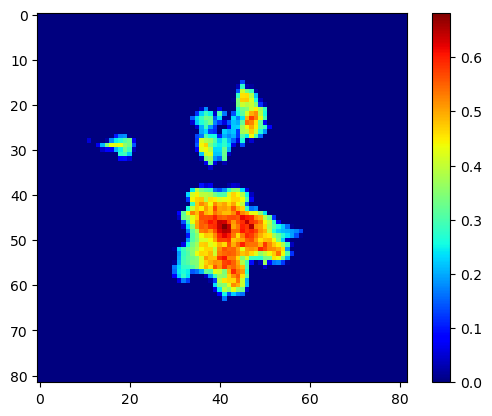

layer No.2


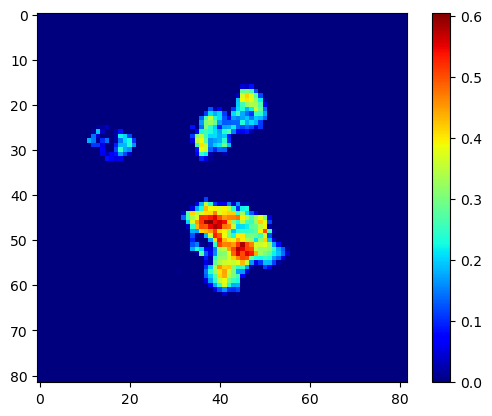

layer No.3


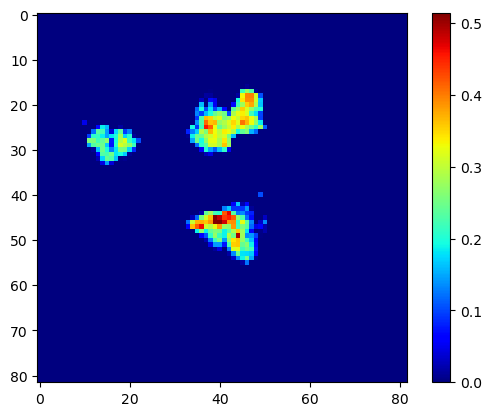

layer No.4


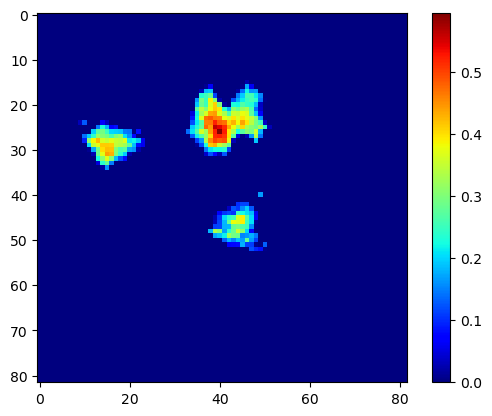

layer No.5


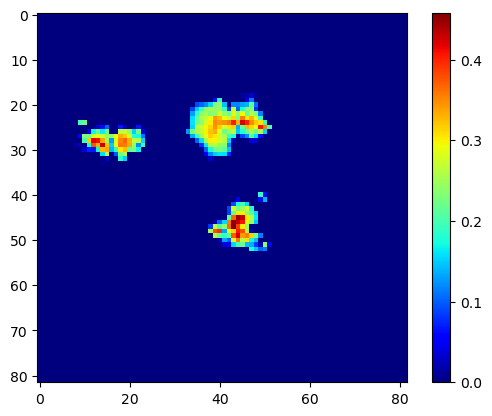

layer No.6


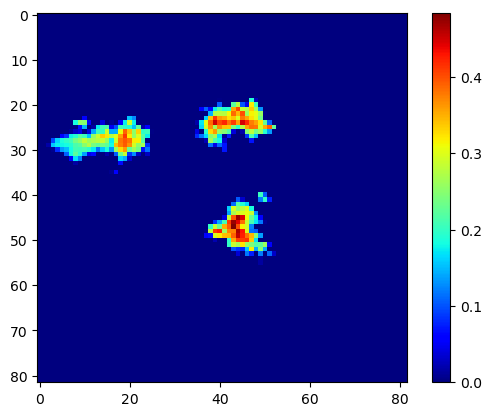

layer No.7


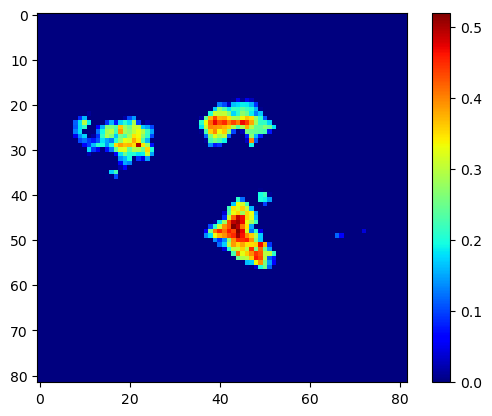

layer No.8


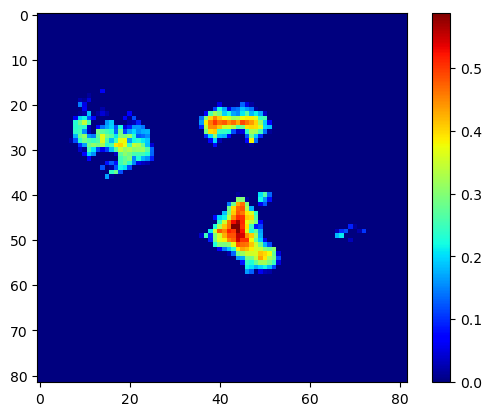

layer No.9


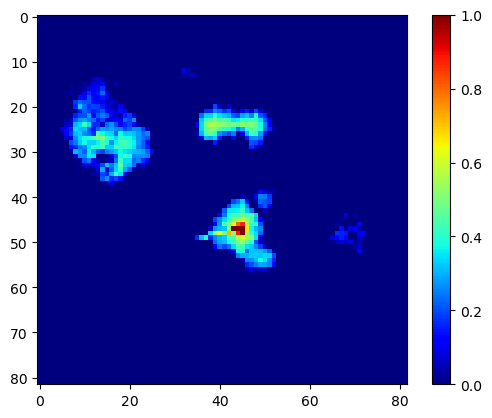

layer No.10


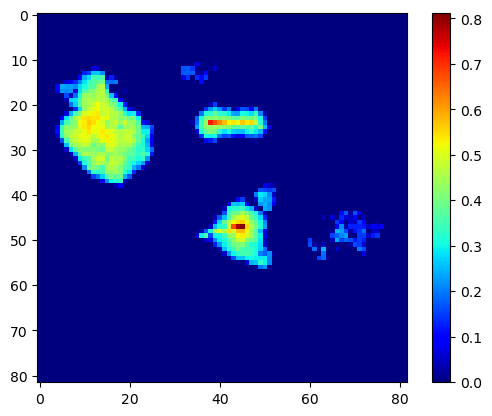

layer No.11


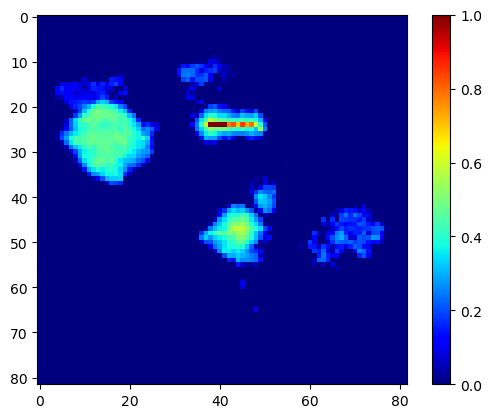

layer No.12


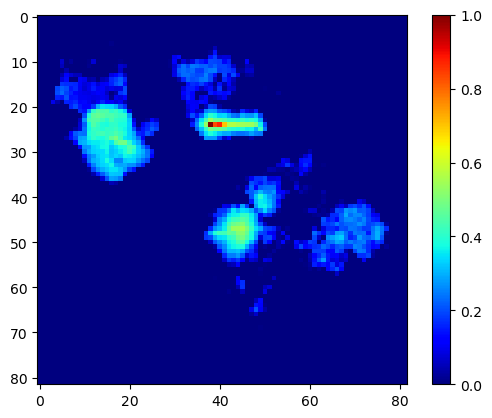

layer No.13


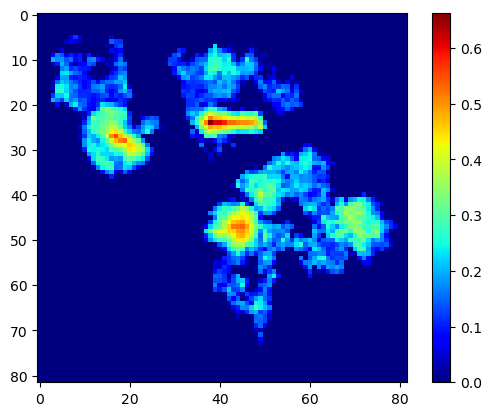

layer No.14


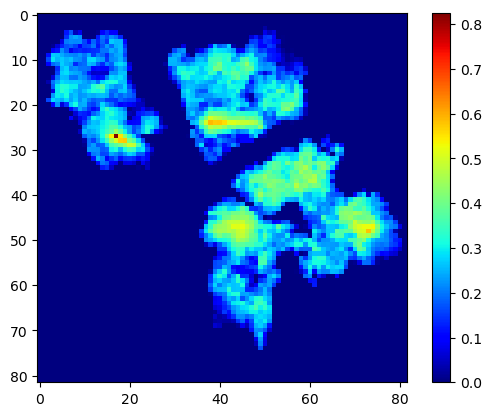

layer No.15


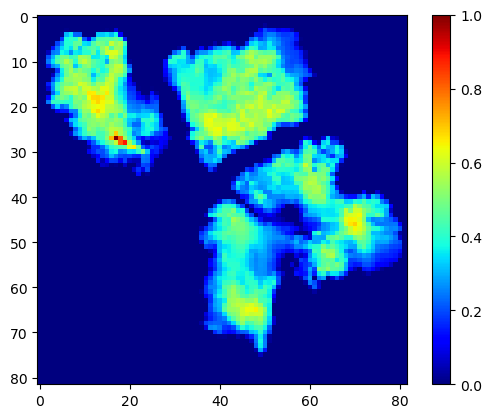

layer No.16


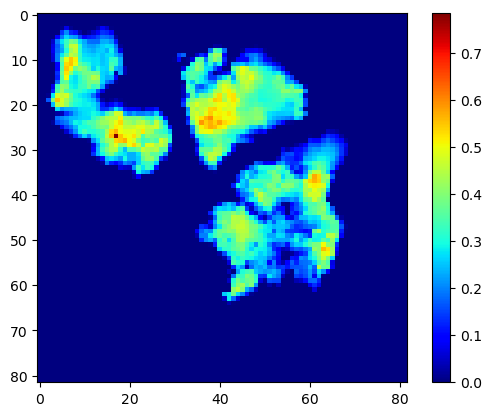

layer No.17


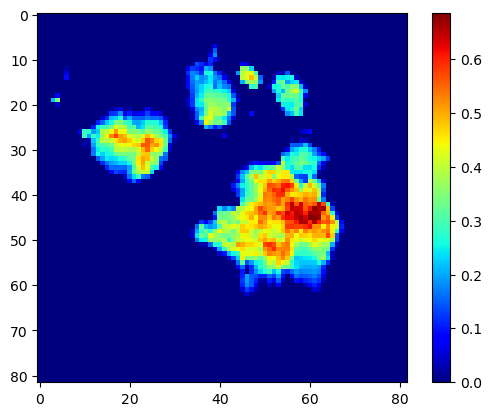

layer No.18


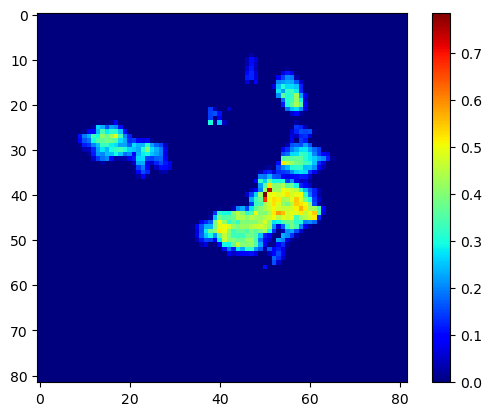

layer No.19


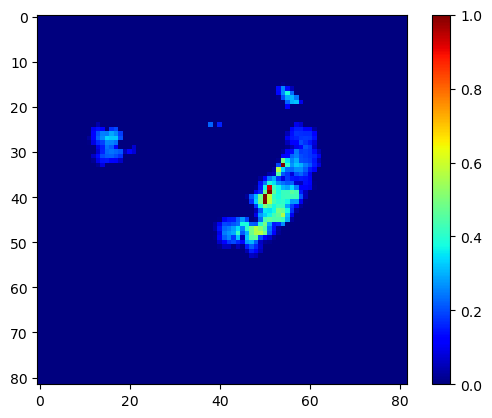

layer No.20


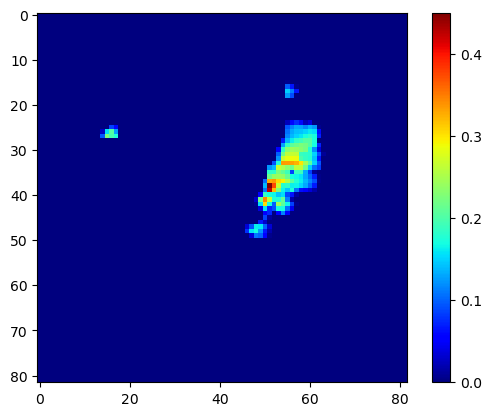

In [14]:
for i in range(data_object_reshape.shape[2]):
    print('layer No.'+str(i+1))
    plt.figure()
    plt.imshow(data_object_reshape[:,:,i,10])
    plt.set_cmap('jet')
    plt.colorbar()
    plt.show()

In [15]:
742269*1.868*365/1e9 #kg/day

0.50609384958

In [16]:
import os, math
raw_dir=os.getcwd()

In [22]:
grids = [82,82,20]

In [23]:
fileName = raw_dir+"/PERMX.DAT"
size_x = grids[0]
size_y = grids[1]
size_z = grids[2]

perm = np.zeros(size_x*size_y*size_z)
perm_log = np.zeros(size_x*size_y*size_z)

with open(fileName) as f:
    lines = f.readlines()
for i in range(len(lines)-2):
    perm[i] = float(lines[i+1])
    perm_log[i] = math.log(perm[i])

layer No.1


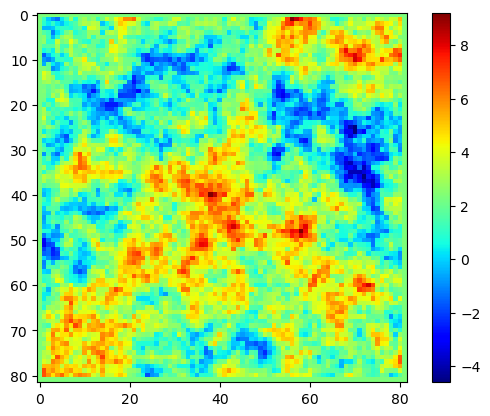

layer No.2


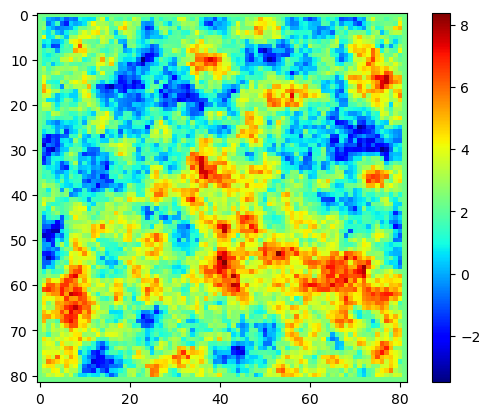

layer No.3


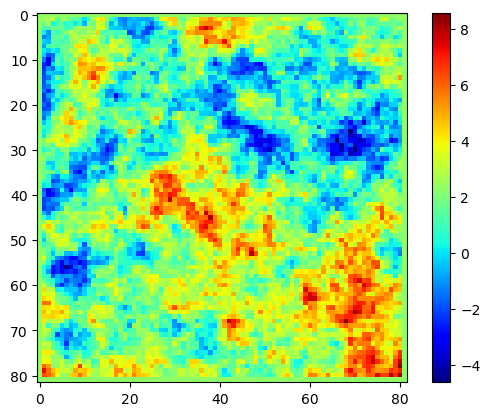

layer No.4


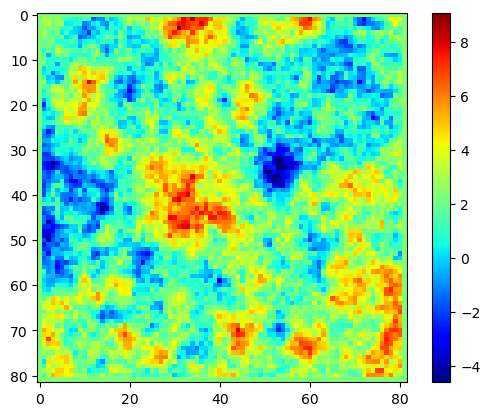

layer No.5


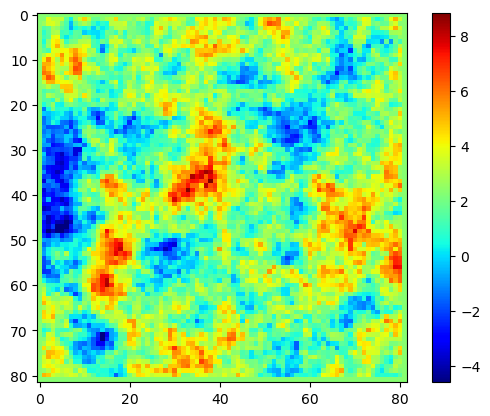

layer No.6


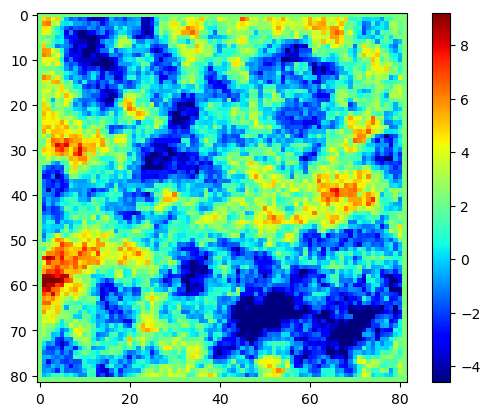

layer No.7


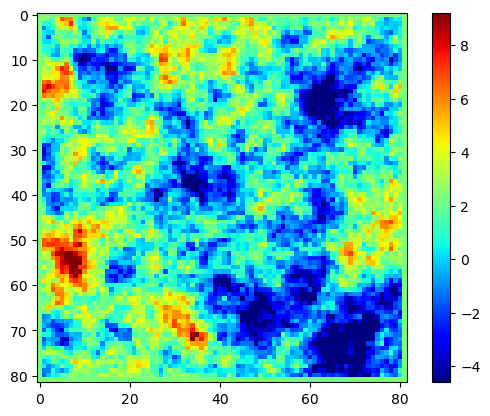

layer No.8


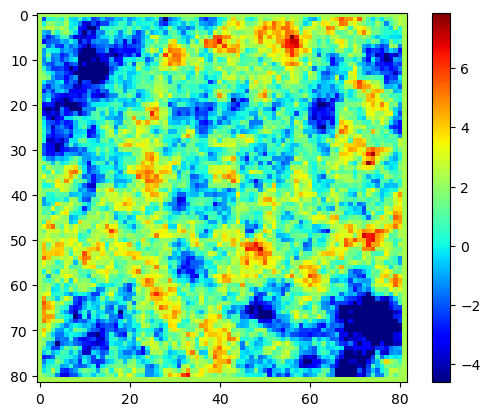

layer No.9


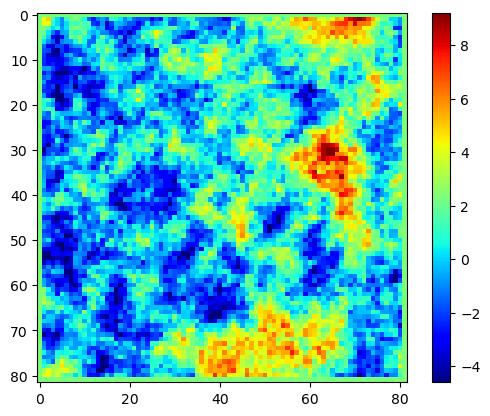

layer No.10


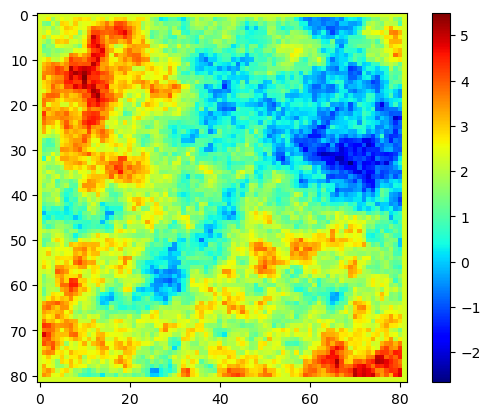

layer No.11


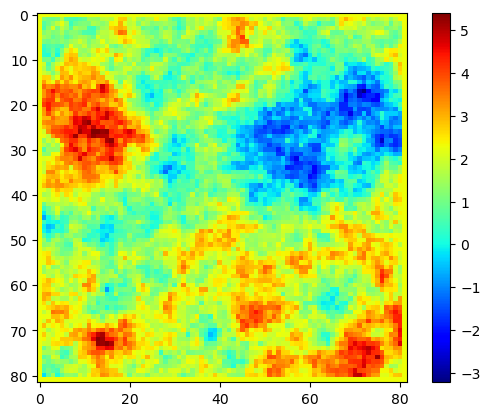

layer No.12


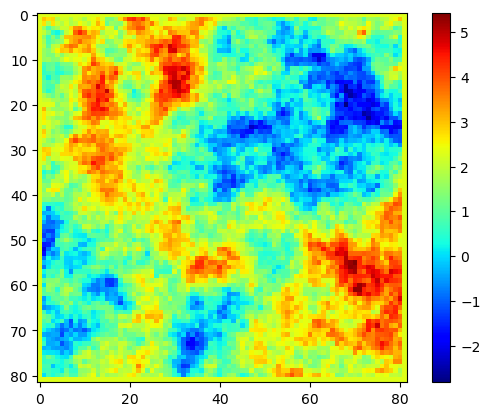

layer No.13


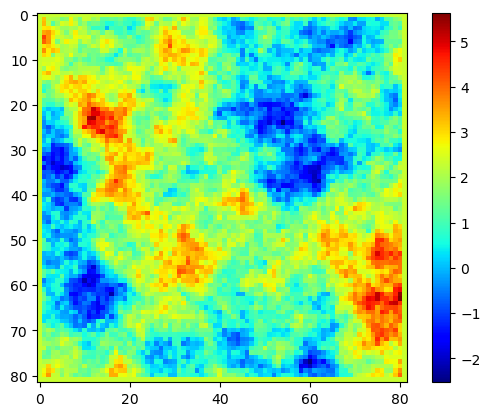

layer No.14


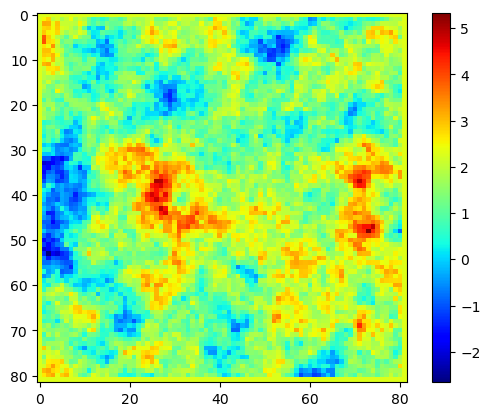

layer No.15


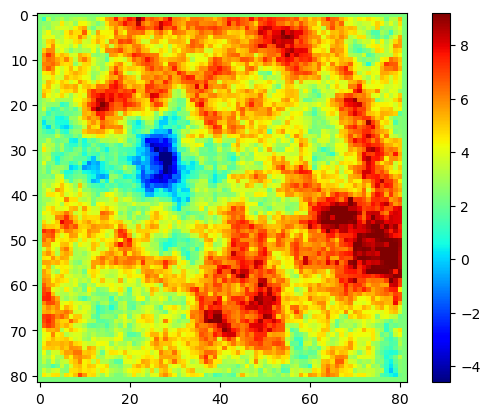

layer No.16


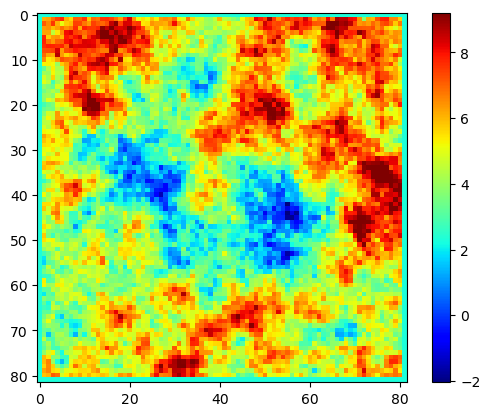

layer No.17


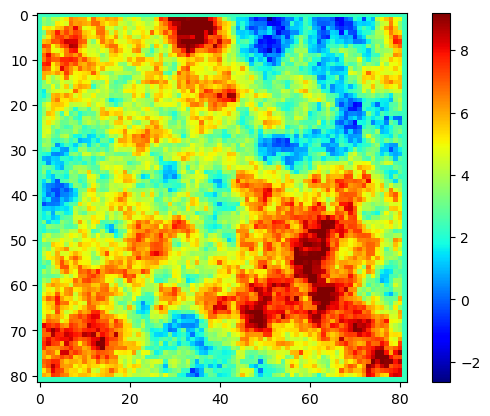

layer No.18


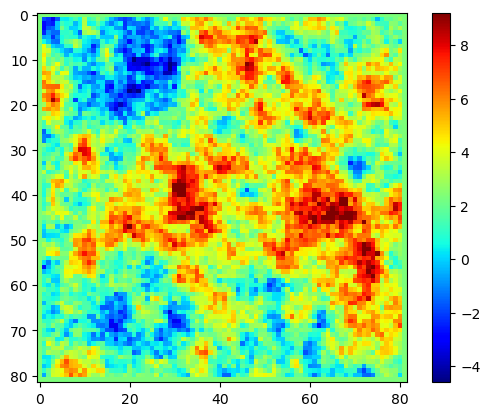

layer No.19


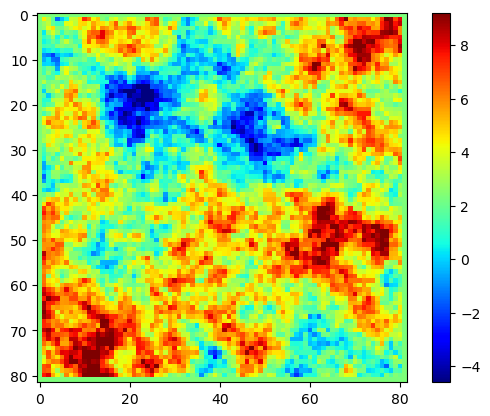

layer No.20


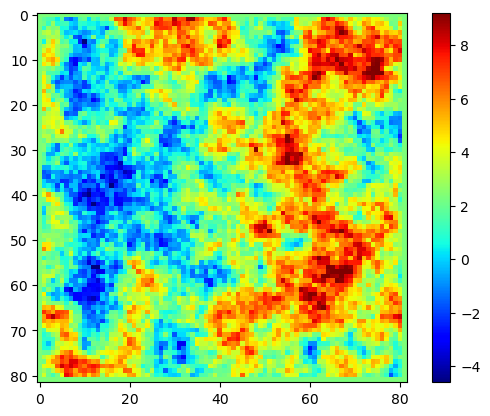

In [24]:
perm_log_reshape = perm_log.reshape(size_x,size_y,size_z,order = 'F')
for i in range(data_object_reshape.shape[2]):
    print('layer No.'+str(i+1))
    plt.figure()
    plt.imshow(perm_log_reshape[:,:,i])
    plt.set_cmap('jet')
    plt.colorbar()
    plt.show()

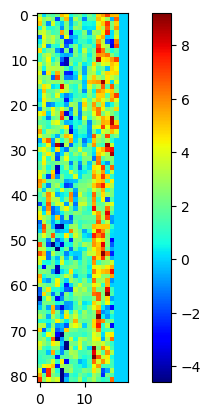

In [20]:
plt.figure()
plt.imshow(perm_log_reshape[40,:,:])
plt.set_cmap('jet')
plt.colorbar()
plt.show()